In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


0.00047770700636942675


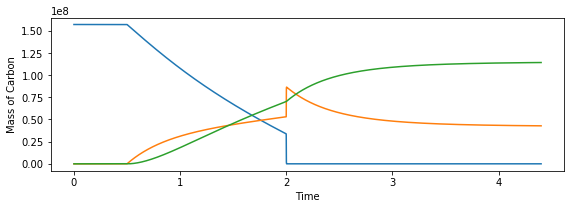

In [22]:
from scipy.integrate import odeint
#help(odeint)    # Uncomment to view the help file for this function

def calc_t_2(cMa0, cMa_2, t_1, tau_1):
    return tau_1 * (-(cMa_2/cMa0) + 1) + t_1

def f(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_2, t_p, tf, tau_1, tau_2, cMa0, cMa_t2, cMmp, cFmap, cMccp, cFccmp = params
    #tau, cMmp, cFmap, cMccp, cFccmp, tp, tf = params
    
    if (t == t_2):
        cMa = cMa_t2
        
    if (t_0 <= t and t < t_1):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - 0,
                  0 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    elif (t_1 <= t < t_2):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1,
                  cMa0/tau_1 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    else:
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa/tau_2,
                  cMa/tau_2 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]

    return derivs

# Parameters
t_0 = 0   #Gyr
t_1 = 0.5 #Gyr
t_p = 4.4  #Gyr

tau_1 = 1.5 #Gyr
cMa0 = 1.57e8 #Gt
cMa_t2 = 5e4 #Gt
tau_2 = cMa_t2 * (tau_1/cMa0)
print(tau_2)
#F_ccm = 35e-3 #Gt/yr
#F_acc = 105e-3 #Gt/yr
#cMa_tp = 2e3 #Gt
#tau_2 = cMa_tp/F_ccm #yr
#cMa_t2 = F_acc * tau_2 #Gt

#tau_1 = cMa0*tau_2/cMa_t2 #yr
#tau_2 = tau_2*1e-9
#tau_1 = tau_1*1e-9

t_2 = calc_t_2(cMa0, cMa_t2, t_1, tau_1) #Gyr

tf = 3.61
ts = 1e4

cFmap = (36/1000)*1e9 #Gt/Gyr
cMmp = 1.15e8
cFccmp = (36/1000)*1e9 #Gt/Gyr
cMccp = 4.2e7

# Initial values
cMa0 = 1.57e8
cMcc0 = 0
cMm0 = 0

# Bundle parameters for ODE solver
#params = [tau, cMmp, cFmap, cMccp, cFccmp, tp, tf]
#params = [t_0, t_1, t_2, t_p, tf, tau_1, tau_2, cMa0, cMa_t2, cMmp, cFmap, cMccp, cFccmp]
params = [t_0, t_1, t_2, t_p, tf, tau_1, tau_2, cMa0, cMa_t2, cMmp, cFmap, cMccp, cFccmp]
# Bundle initial conditions for ODE solver
y0 = [cMa0, cMcc0, cMm0]

t = np.linspace(t_0,t_p,ts)
solution = odeint(f, y0, t, args=(params,))
fig = plt.figure(1, figsize=(8,8))

# Plot cMa as a function of time
ax1 = fig.add_subplot(311)
ax1.plot(t, solution[:,0])
ax1.set_xlabel('Time')
ax1.set_ylabel('Mass of Carbon in Atmosphere')

#tmp = np.empty(len(t))
#tmp.fill(0)
#ax1.plot(t,tmp)
#print(solution[:,0] - 0)

# Plot cMcc as a function of time
ax2 = fig.add_subplot(311)
ax2.plot(t, solution[:,1])
ax2.set_xlabel('Time')
ax2.set_ylabel('Mass of Carbon in Continental Crust')

# Plot cMm as a function of time
ax3 = fig.add_subplot(311)
ax3.plot(t, solution[:,2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Mass of Carbon')

plt.tight_layout()
plt.show()

[  1.57000000e+08   1.50988967e+08   1.45208077e+08   1.39648519e+08
   1.34301819e+08   1.29159827e+08   1.24214706e+08   1.19458918e+08
   1.14885214e+08   1.10486623e+08   1.06256440e+08   1.02188217e+08
   9.82757533e+07   9.45130856e+07   9.08944786e+07   8.74144165e+07
   8.40675951e+07   8.08489129e+07   7.77534639e+07   7.47765298e+07
   7.19135731e+07   6.91602300e+07   6.65123036e+07   6.39657580e+07
   6.15167115e+07   5.91614313e+07   5.68963273e+07   5.47179469e+07
   5.26229699e+07   5.06082029e+07   4.86705749e+07   4.68071326e+07
   4.50150356e+07   4.32915523e+07   4.16340558e+07   4.00400195e+07
   3.85070139e+07   3.70327022e+07   3.56148372e+07   3.42512578e+07
   3.29398855e+07   3.16787215e+07   3.04658435e+07   2.92994027e+07
   2.81776213e+07   2.70987893e+07   2.60612623e+07   2.50634591e+07
   2.41038585e+07   2.31809980e+07   2.22934709e+07   2.14399245e+07
   2.06190576e+07   1.98296191e+07   1.90704057e+07   1.83402602e+07
   1.76380697e+07   1.69627638e+07

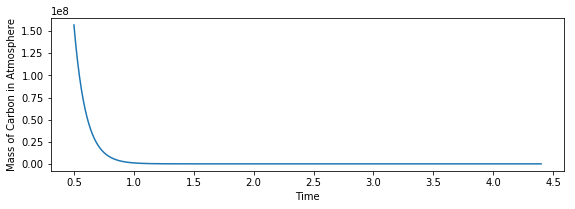

In [15]:
from scipy.integrate import odeint
#help(odeint)    # Uncomment to view the help file for this function

def f(y, t, params):
    cMa, cMcc, cMm = y
    tau, cMmp, cFmap, cMccp, cFccmp, tp, tf = params
    derivs = [(cMm/cMmp)*cFmap*exp((tp - t)/tf) - cMa/tau,
             cMa/tau - (cMcc/cMccp)*cFccmp*exp((tp - t)/tf),
             ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((tp-t)/tf)]
    return derivs

# Parameters
t0 = 0.5
tp = 4.4
tf = 3.61
ts = 1e3

tau = .1
cFmap = 0 #(36/1000)*1e9
cMmp = 1.15e8
cFccmp = 0 #(36/1000)*1e9
cMccp = 4.2e7

# Initial values
cMa0 = 1.57e8
cMcc0 = 0
cMm0 = 0

# Bundle parameters for ODE solver
params = [tau, cMmp, cFmap, cMccp, cFccmp, tp, tf]

# Bundle initial conditions for ODE solver
y0 = [cMa0, cMcc0, cMm0]

t = np.linspace(t0,tp,ts)
solution = odeint(f, y0, t, args=(params,))
fig = plt.figure(1, figsize=(8,8))

# Plot cMa as a function of time
ax1 = fig.add_subplot(311)
ax1.plot(t, solution[:,0])
ax1.set_xlabel('Time')
ax1.set_ylabel('Mass of Carbon in Atmosphere')
print(solution[:,0])

# Plot cMcc as a function of time
#ax2 = fig.add_subplot(311)
#ax2.plot(t, solution[:,1])
#ax2.set_xlabel('Time')
#ax2.set_ylabel('Mass of Carbon in Continental Crust')

# Plot cMm as a function of time
#ax3 = fig.add_subplot(311)
#ax3.plot(t, solution[:,2])
#ax3.set_xlabel('Time')
#ax3.set_ylabel('Mass of Carbon')

plt.tight_layout()
plt.show()

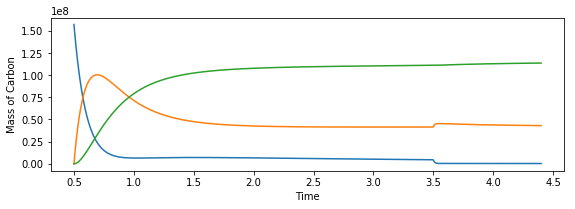

In [19]:
from scipy.integrate import odeint
#help(odeint)    # Uncomment to view the help file for this function

def calculate_cFacc(cMa, t):
    return (-cMa/(1.57e8) + 1)/(t)

def f(y, t, params):
    cMa, cMcc, cMm = y
    cMmp, cFmap, cMccp, cFccmp, tp, tf = params
    tau = 1
    if (450e-3 <= t and t < 3.5):
        tau = 100e-3
    elif (3.5 <= t and t <= tp):
        tau = 10e-3   
    derivs = [(cMm/cMmp)*cFmap*exp((tp - t)/tf) - cMa/tau,
         cMa/tau - (cMcc/cMccp)*cFccmp*exp((tp - t)/tf),
         ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((tp-t)/tf)]
    return derivs

# Parameters
t0 = 0.5
tp = 4.4
tf = 3.61
ts = 1e3

#tau = .01
cFmap = (36/1000)*1e9
cMmp = 1.15e8
cFccmp = (36/1000)*1e9
cMccp = 4.2e7

# Initial values
cMa0 = 1.57e8
cMcc0 = 0
cMm0 = 0

# Bundle parameters for ODE solver
params = [cMmp, cFmap, cMccp, cFccmp, tp, tf]

# Bundle initial conditions for ODE solver
y0 = [cMa0, cMcc0, cMm0]

t = np.linspace(t0,tp,ts)
solution = odeint(f, y0, t, args=(params,))
fig = plt.figure(1, figsize=(8,8))

# Plot cMa as a function of time
ax1 = fig.add_subplot(311)
ax1.plot(t, solution[:,0])
ax1.set_xlabel('Time')
ax1.set_ylabel('Mass of Carbon in Atmosphere')

#tmp = np.empty(len(t))
#tmp.fill(0)
#ax1.plot(t,tmp)
#print(solution[:,0] - 0)

# Plot cMcc as a function of time
ax2 = fig.add_subplot(311)
ax2.plot(t, solution[:,1])
ax2.set_xlabel('Time')
ax2.set_ylabel('Mass of Carbon in Continental Crust')

# Plot cMm as a function of time
ax3 = fig.add_subplot(311)
ax3.plot(t, solution[:,2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Mass of Carbon')

plt.tight_layout()
plt.show()